### Market Value Prediction with XGBoost Regressor

### Short look up in the Data + Imports

- numpy library as np: Provides support for large, multi-dimensional arrays and matrices in Python.
    pandas library as pd: A powerful data manipulation and analysis tool in Python, providing data structures and functions for handling and analyzing structured data.
- seaborn library as sns: A data visualization library based on matplotlib, providing a high-level interface for creating informative and attractive statistical graphics.
- matplotlib.pyplot module as plt: A plotting library in Python that provides a MATLAB-like interface for creating various types of plots, charts, and visualizations.
- ColumnTransformer class from sklearn.compose: A transformer that applies different transformations to different columns of a dataset, useful for preprocessing data.
- OneHotEncoder class from sklearn.preprocessing: Used for one-hot encoding categorical features, converting them into binary vectors suitable for machine learning algorithms.
- mean_squared_error and mean_absolute_error functions from sklearn.metrics: Used to evaluate the performance of regression models by calculating the mean squared error and mean absolute error between predicted and actual values.
- train_test_split function from sklearn.model_selection: Used to split a dataset into training and testing subsets for model evaluation and validation.
- xgboost library: An optimized implementation of the gradient boosting algorithm, commonly used for building and training gradient boosting models.
- GridSearchCV class from sklearn.model_selection: A method for hyperparameter tuning that exhaustively searches over specified parameter values to find the best combination of hyperparameters for a given model.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.model_selection import GridSearchCV

df_players = pd.read_csv('../DataSets/Market/top5_leagues_player.csv', index_col = [0])
df_players.head()

,name,full_name,age,height,nationality,place_of_birth,price,max_price,position,shirt_nr,foot,club,contract_expires,joined_club,player_agent,outfitter,league
0,Ederson,NaN,29,1.88,Brazil Portugal,Osasco (SP),45.00,70.0,Goalkeeper,31,left,Man City,2026-06-30,2017-07-01,Gestifute,Puma,EPL
1,Stefan Ortega,Stefan Ortega Moreno,30,1.85,Germany Spain,Hofgeismar,6.00,6.0,Goalkeeper,18,right,Man City,2025-06-30,2022-07-01,neblung ...,NaN,EPL
2,Scott Carson,Scott Paul Carson,37,1.88,England,Whitehaven,0.25,6.0,Goalkeeper,33,right,Man City,2023-06-30,2021-07-20,Wasserman,Puma,EPL
3,Rúben Dias,Rúben Santos Gato Alves Dias,26,1.87,Portugal,Amadora,75.00,75.0,Defender - Centre-Back,3,right,Man City,2027-06-30,2020-09-29,Gestifute,Nike,EPL
4,Nathan Aké,Nathan Benjamin Aké,28,1.80,Netherlands Cote d'Ivoire,Den Haag,35.00,40.0,Defender - Centre-Back,6,left,Man City,2025-06-30,2020-08-05,Wasserman,Nike,EPL


In [2]:
df_players.describe()

,age,height,price,max_price,shirt_nr
count,2612.000000,2601.000000,2602.000000,2606.000000,2612.000000
mean,26.305513,1.830892,10.650711,17.304729,20.495789
std,4.645297,0.067255,15.773271,21.948577,17.914206
min,17.000000,1.630000,0.025000,0.025000,1.000000
25%,23.000000,1.780000,1.800000,3.500000,8.000000
50%,26.000000,1.830000,4.500000,10.000000,17.000000
75%,30.000000,1.880000,13.000000,22.000000,27.000000
max,42.000000,2.060000,180.000000,200.000000,99.000000


In [3]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2612 entries, 0 to 2611
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2612 non-null   object 
 1   full_name         1480 non-null   object 
 2   age               2612 non-null   int64  
 3   height            2601 non-null   float64
 4   nationality       2612 non-null   object 
 5   place_of_birth    2595 non-null   object 
 6   price             2602 non-null   float64
 7   max_price         2606 non-null   float64
 8   position          2612 non-null   object 
 9   shirt_nr          2612 non-null   int64  
 10  foot              2576 non-null   object 
 11  club              2612 non-null   object 
 12  contract_expires  2544 non-null   object 
 13  joined_club       2612 non-null   object 
 14  player_agent      2353 non-null   object 
 15  outfitter         1003 non-null   object 
 16  league            2612 non-null   object 


### nan value handling

The two columns with too much nan values become 'none' string to replace the nan values with a categorical value. Afterwards it is easy to drop rows with nan values.

In [4]:
# filter columns with empty values
empty_cols = df_players.columns[df_players.isna().any()].tolist()

# create separate df only with columns which consist empty values
df_isnull = df_players[empty_cols]

print(df_isnull.isnull().sum())

full_name           1132
height                11
place_of_birth        17
price                 10
max_price              6
foot                  36
contract_expires      68
player_agent         259
outfitter           1609
dtype: int64


This small table shows that there are three columns to handle. The remaining amount is too small, so we can drop it. These three columns can also be reduced because the full name is unnecessary for predictions. At least the columns 'player_agent' and 'outfitter' need to be handled.

In [5]:
df_players = df_players.dropna(subset=['contract_expires', 'foot', 'height', 'foot', 'price', 'max_price'])
df_players.shape

(2498, 17)

<AxesSubplot:>

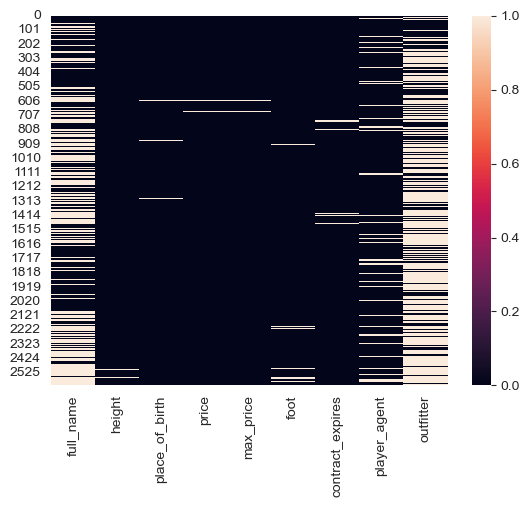

In [6]:
sns.heatmap(df_isnull.isnull())

And now a look into the critical columns

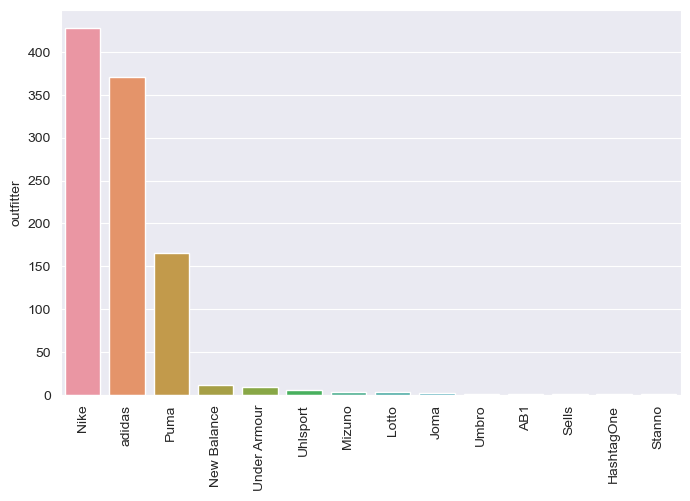

In [7]:
plt.figure(figsize=(8,5))

outfitter_counts = df_isnull['outfitter'].value_counts()
sns.barplot(data=df_isnull, x=outfitter_counts.index, y=outfitter_counts)

# Rotate the x-axis labels by 90 degrees
ax = plt.gca()
ax.tick_params(axis='x', labelrotation=90)

For the 'player_agent' only the top 10 and the bottom 10

<AxesSubplot:xlabel='player_agent'>

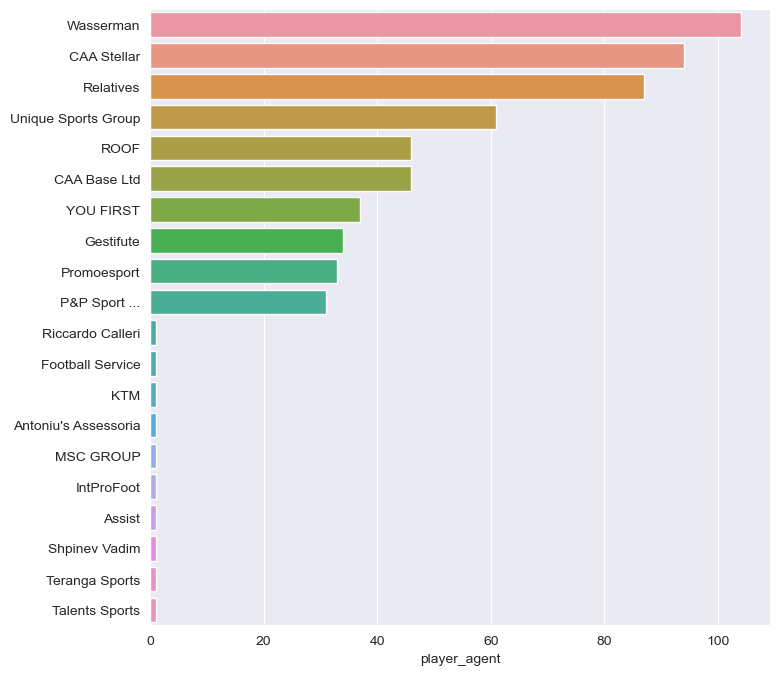

In [8]:
plt.figure(figsize=(8,8))

outfitter_counts = df_isnull['player_agent'].value_counts()

# only top 10
top_10 = outfitter_counts.head(10)
last_10 = outfitter_counts.tail(10)
plot_data = pd.concat([top_10, last_10])

sns.barplot(data=df_isnull, x=plot_data, y=plot_data.index)

One option to deal with empyt categorical values is to replace them with an 'unknowen' value

In [9]:
# hsould be valid because only 'player_agent' and 'outfitter' have nan values
df_players = df_players.replace(np.nan, 'unknowen')

In [10]:
df_players.head()

,name,full_name,age,height,nationality,place_of_birth,price,max_price,position,shirt_nr,foot,club,contract_expires,joined_club,player_agent,outfitter,league
0,Ederson,unknowen,29,1.88,Brazil Portugal,Osasco (SP),45.00,70.0,Goalkeeper,31,left,Man City,2026-06-30,2017-07-01,Gestifute,Puma,EPL
1,Stefan Ortega,Stefan Ortega Moreno,30,1.85,Germany Spain,Hofgeismar,6.00,6.0,Goalkeeper,18,right,Man City,2025-06-30,2022-07-01,neblung ...,unknowen,EPL
2,Scott Carson,Scott Paul Carson,37,1.88,England,Whitehaven,0.25,6.0,Goalkeeper,33,right,Man City,2023-06-30,2021-07-20,Wasserman,Puma,EPL
3,Rúben Dias,Rúben Santos Gato Alves Dias,26,1.87,Portugal,Amadora,75.00,75.0,Defender - Centre-Back,3,right,Man City,2027-06-30,2020-09-29,Gestifute,Nike,EPL
4,Nathan Aké,Nathan Benjamin Aké,28,1.80,Netherlands Cote d'Ivoire,Den Haag,35.00,40.0,Defender - Centre-Back,6,left,Man City,2025-06-30,2020-08-05,Wasserman,Nike,EPL


### Feature tracking

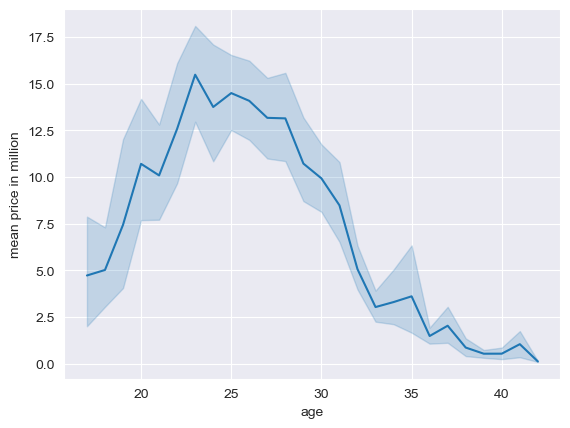

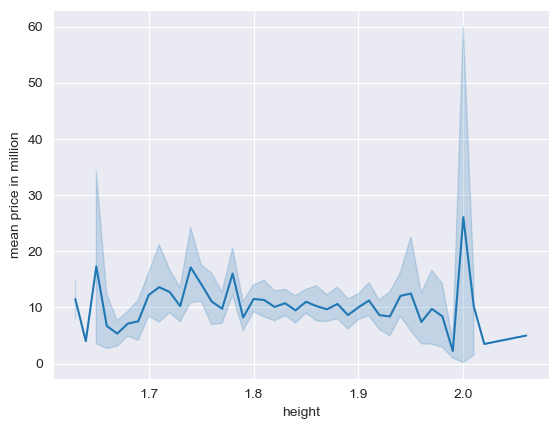

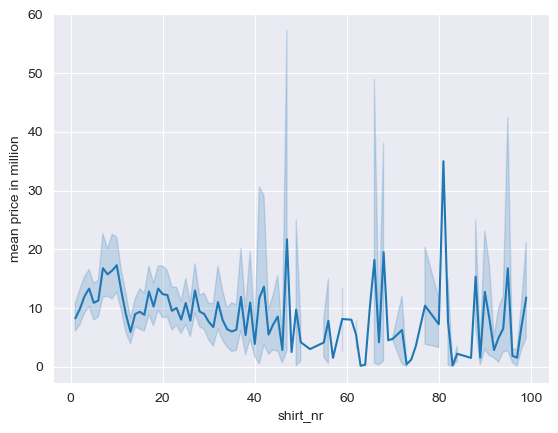

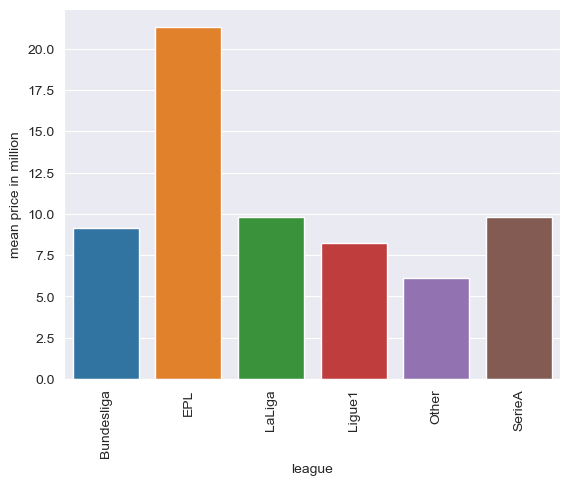

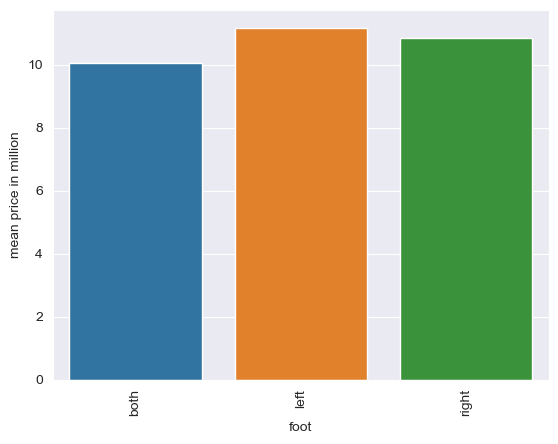

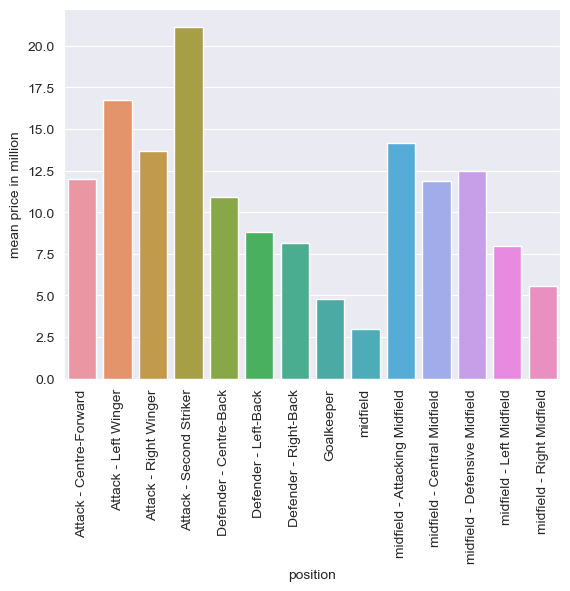

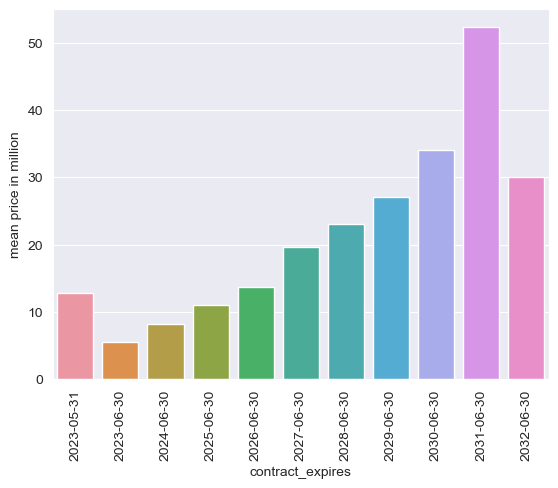

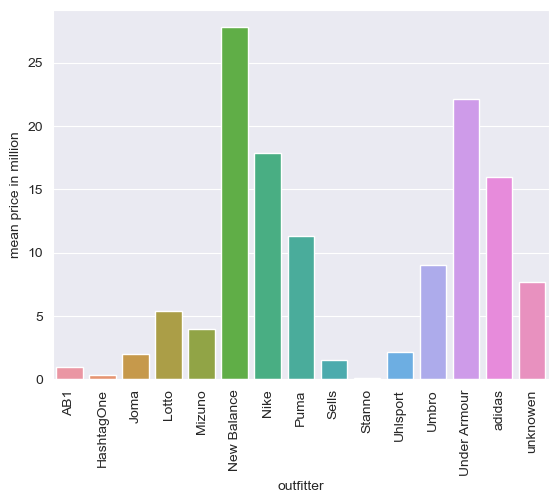

In [11]:
def plotting(df, feature):
    df_mean = df.groupby(feature)['price'].mean().reset_index()
    sns.barplot(data=df_mean, x=feature, y='price')

    # Rotate the x-axis labels by 90 degrees
    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation=90)
    plt.ylabel('mean price in million')
    plt.show()

def plottingLine(df, feature):
    sns.lineplot(data=df, x=feature, y='price')
    plt.ylabel('mean price in million')
    plt.show()


feature_list = ['league', 'foot', 'position', 'contract_expires', 'outfitter']

numarical_features = ['age', 'height', 'shirt_nr']

for feature in numarical_features:
    plottingLine(df_players, feature)

for feature in feature_list:
    plotting(df_players, feature)

All of these variables clearly influence the price or can be used to predict the price. If you look at the other variables, you can't see the influence because of the high variety. That's why you have to rely on domain knowledge. At least a look into the correlation matrix is always useful.

<AxesSubplot:>

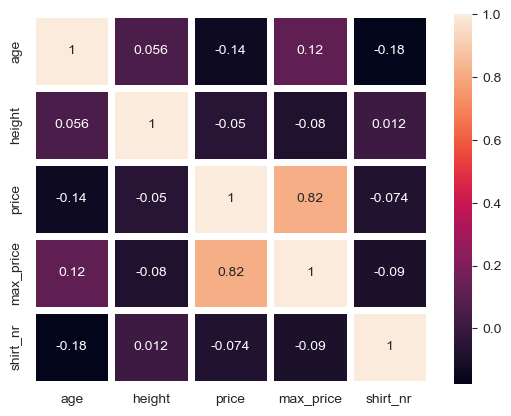

In [12]:
sns.heatmap(df_players.corr(), annot= True, linewidth = 5)

After the correlation matrix it is clearly evident that the max price would be a nice feature but the highest price could be the price, so don't using it is the better option

### Variable Usefulness for Predicting Price

1. Age: Age is likely to be a useful variable for predicting price as younger players generally have higher market values due to their potential for growth and longer career ahead.

2. Height: Height might have some influence on the price as certain positions or playing styles may favor taller players. However, its impact on price may not be as significant compared to other variables.

3. Club: Club affiliation is an important variable for predicting price. Players from high-profile clubs or clubs known for producing top talent are often valued more highly in the market.

4. Position: Position is a crucial factor in determining price. Different positions have varying levels of demand and scarcity, leading to variations in market values.

5. Contract Expiry Date: The remaining duration of a player's contract can impact their price. Players with longer contract terms may have higher values due to increased stability and reduced transfer urgency.

5. Contract Start Date: The start date of a player's current contract may have less influence on predicting price compared to other variables. It is more indicative of the player's history with the club rather than their current market value.

6. Agency/Representative: The player's agency or representative is not directly related to their market value. It is more of a logistical detail and does not provide significant insight into predicting price.

7. Sponsorship Brand: The sponsorship brand associated with a player does not have a direct impact on their market value. While brand endorsements can increase a player's overall earnings, it may not be a significant factor in price prediction.

8. Right/Left-Footed: A player's dominant foot is unlikely to have a substantial impact on their market value, but left-footed are more rarer than right-footed because they are less.

9. League: It very important because pl player have a higher market value than bundesliga player.

10. Nationality: A player's nationality can have an impact on this prediction, because there are nations which don't play an important role in football.

11. Max Price (Excluded): The "max price" variable should be excluded from the prediction model because it represents the actual target variable we want to predict to much. Including it as a feature would result in data leakage and lead to an overly optimistic evaluation of the model's performance.

Note: The above analysis is based on general assumptions and domain knowledge. It is recommended to validate the significance of these variables through statistical analysis and feature selection techniques specific to the dataset and prediction task at hand.

In [13]:
df_target = df_players[['price']]
df_features = df_players[['age', 'height', 'league','foot', 'position', 'club',
                          'contract_expires', 'joined_club', 'player_agent', 'outfitter', 'nationality']]

### One Hot Encoding

In the Data are many categorical features and the Random Forest Regressor can't handle those. Because of this One Hot Encoding is used. This implies that the categorical features will be split into different binary columns which can tell the model if this category is true or not.Nevertheless, first is a look into those variables needed.

In [14]:
for column in df_features.columns:
    unique_values = df_features[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'age': [29 30 37 26 28 27 22 32 18 20 31 21 23 19 38 24 33 25 36 35 34 41 39 17
 40 42]
Unique values in column 'height': [1.88 1.85 1.87 1.8  1.89 1.71 1.83 1.69 1.91 1.79 1.77 1.81 1.73 1.82
 1.95 1.7  1.94 1.86 1.93 1.92 1.78 1.9  1.75 1.72 1.74 1.96 1.84 1.97
 2.01 1.98 1.63 1.76 1.67 1.99 1.65 2.   1.68 1.66 2.02 1.64 2.06]
Unique values in column 'league': ['EPL' 'Other' 'Bundesliga' 'SerieA' 'LaLiga' 'Ligue1']
Unique values in column 'foot': ['left' 'right' 'both']
Unique values in column 'position': ['Goalkeeper' 'Defender - Centre-Back' 'Defender - Left-Back'
 'Defender - Right-Back' 'midfield - Defensive Midfield'
 'midfield - Central Midfield' 'midfield - Attacking Midfield'
 'Attack - Left Winger' 'Attack - Right Winger' 'Attack - Centre-Forward'
 'Attack - Second Striker' 'midfield - Left Midfield'
 'midfield - Right Midfield' 'midfield']
Unique values in column 'club': ['Man City' 'Chelsea' 'Chelsea U21' 'Arsenal' 'Liverpool' 'Man Utd'
 'Tottenham'

Now we use the ColumnTransformer to apply the One Hot Encoding

In [15]:
columns_to_encode = ['league' ,'foot', 'position', 'club', 'contract_expires', 'joined_club', 'player_agent', 'outfitter', 'nationality']

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), columns_to_encode)], remainder='passthrough')

df_features_encoded = ct.fit_transform(df_features)

df_features_encoded.shape

(2498, 1802)

### Train and Test Split¶

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df_features_encoded, df_target, test_size = 0.3, random_state=22)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

x_train: (1748, 1802)
x_test: (750, 1802)
y_train: (1748,)
y_test: (750,)


### Hyperparameter tuning

Using GridSearch for hyperparameter tuning is a good option because it allows us to systematically search through different combinations of hyperparameters and find the optimal configuration for our model. It automates the process of tuning hyperparameters, saving time(not computing time :p) and effort. GridSearch performs an exhaustive search over the specified hyperparameter grid, evaluating each combination using cross-validation. This helps us find the hyperparameters that yield the best performance based on the chosen evaluation metric. By using GridSearch, we can effectively optimize our model without the need for manual trial and error.

In [17]:
param_grid = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [0.03, 0.05],
              'max_depth': [4, 7],
              'min_child_weight': [2,3,4],
              'subsample': [0.5, 0.3],
              'colsample_bytree': [0.7],
              'n_estimators': [300]}

xgb = xgboost.XGBRegressor(objective= 'reg:linear')

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv = 4)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print(grid_search.best_estimator_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, nthread=4, num_parallel_tree=None,
             predictor=None, ...)


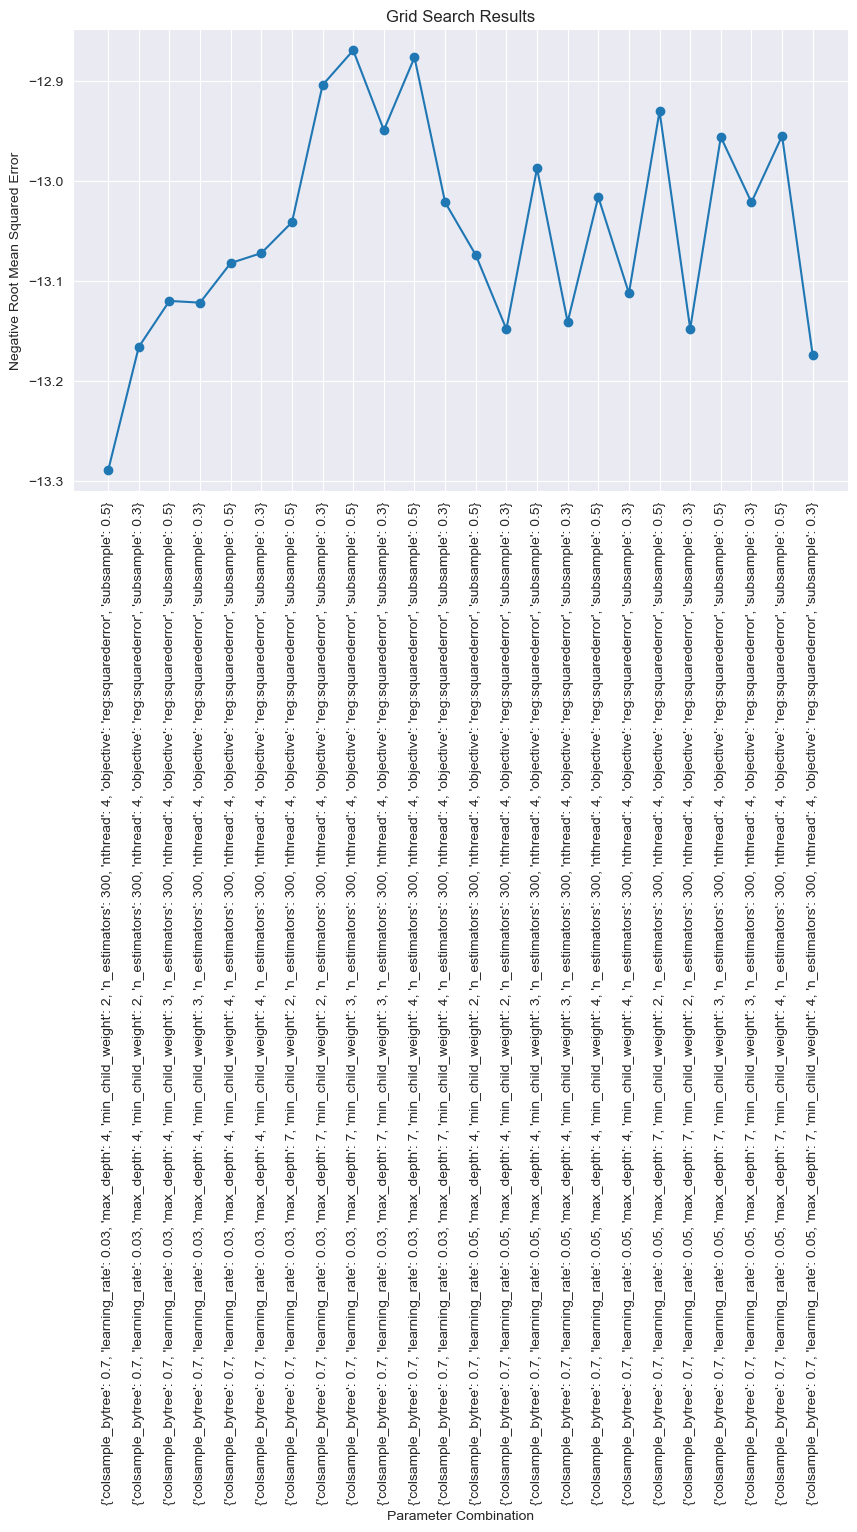

In [18]:
# Access the grid search results
results = grid_search.cv_results_
params = results['params']
mean_scores = results['mean_test_score']

# Visualize the results using a line plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_scores)), mean_scores, marker='o')
plt.xlabel('Parameter Combination')
plt.ylabel('Negative Root Mean Squared Error')
plt.title('Grid Search Results')
plt.xticks(range(len(mean_scores)), params, rotation=90)
plt.show()

### Modeling

The tuned hyperparameter are used to set up the model

In [19]:
best_xgb = xgboost.XGBRegressor( **best_params)

best_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, nthread=4, num_parallel_tree=None,
             predictor=None, ...)

### Evaluation

Here the values are predicted and also evaluated by MAE, MSE and RMSE. The important comparison is between RMSE and MAE because there we can see how the outlayers or large errors will impact the result.

In [ ]:
pred = best_xgb.predict(x_test)

# evaluation
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print('mean absolute error: ',mae)
print('mean squared error: ',mse)
print('root mean squared error: ',rmse)

While the dataset provides valuable player information, it is crucial to acknowledge the limitations in predicting accurate values solely based on individual features. Football, being a highly nuanced and unpredictable sport, requires comprehensive match statistics and in-depth analysis to make precise predictions. Factors like a player's nationality do not directly determine their market value, and relying solely on basic data may lead to inaccurate estimations. It is essential to approach football as the complex and individualistic sport it is, acknowledging the challenges in accurately forecasting player valuations.